# Setting up Spark

In [ ]:
from pyspark.sql import SparkSession

# spark = SparkSession.builder.getOrCreate()

# only use 4 corea
spark = SparkSession.builder.master("local[4]").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/30 20:42:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
spark

In [3]:
spark.sparkContext.defaultParallelism

4

In [ ]:
# spark.stop()

# Preparing NO2 Data

For NO2 data, I will be using OMI NO2 from NASA. This dataset is daily-level ar roughly 0.1deg * 0.1deg resolution. OMI instrument present in a satellite orbits the Earth 14 to 15 times a day and calculate NO2 vertical column density. Vertical Column Density or VCD refers to the total amount of NO2 molecules present from earth surface to the top of the atmosphere. NO2 pollution would be in tons that can be calculated from surface concentrations (NO2 molecules present on earth surface). This can be done using ground based sensors from EPA or PANDORA. 

Even though the data I am using is vertical columns, it still is a very good indicator of NO2 pollution. It is satellite-based data, which means we can do global-level data analysis and evaluation. Besides, the presence of sensors is very scarce and it is not possible to place ground-based sensors throughout the world. That's where satellite-based evaluation come in handy.

<b> Higher OMI NO2 VCD indicates more NO2 emissions from burning of fuel (cars), industries, etc. Furthermore, NO2 irritates the airways in our lungs and nose, causing inflammation and swelling, and is one of the top pollutants to cause respiratory disease like Asthma</b>

I wil be using `OMI_MINDS_NO2` dataset from NASA. You can find more about it from the following link: https://disc.gsfc.nasa.gov/datasets/OMI_MINDS_NO2_1.1/summary?keywords=OMI_MINDS_NO2_1.1


This data is also available on S3. I will be reading the files directly from S3. 

In [1]:
import s3fs
import base64
import json
import os
import requests
import pandas as pd
import numpy as np
import xarray as xr
from tqdm import tqdm
import netCDF4 as nc
from dotenv import load_dotenv

In [ ]:
load_dotenv()

True

In [2]:
s3_endpoint = "https://data.gesdisc.earthdata.nasa.gov/s3credentials"
username = os.getenv("EARTHDATA_USERNAME")
password = os.getenv("EARTHDATA_PASSWORD")


login_resp = requests.get(s3_endpoint, allow_redirects=False)
login_resp.raise_for_status()

auth = f"{username}:{password}"
encoded_auth = base64.b64encode(auth.encode('ascii'))

auth_redirect = requests.post(
    login_resp.headers['location'],
    data={"credentials": encoded_auth},
    headers={"Origin": s3_endpoint},
    allow_redirects=False
)
auth_redirect.raise_for_status()

final = requests.get(auth_redirect.headers['location'], allow_redirects=False)
final.raise_for_status()

results = requests.get(s3_endpoint, cookies={'accessToken': final.cookies['accessToken']})
results.raise_for_status()

creds = json.loads(results.content)

In [3]:
s3_fs = s3fs.S3FileSystem(
        key = creds['accessKeyId'],
        secret = creds['secretAccessKey'],
        token = creds['sessionToken'],
    )

In [4]:
try:
    files = s3_fs.ls("s3://gesdisc-cumulus-prod-protected")
    print("Connection successful! Files found:")
except Exception as e:
    print(f"Connection failed: {e}")

Connection successful! Files found:


We have set up our s3fs object and connected it to NASA's s3 bucket. Next thing will be to go on the NASA GESC DISC website and get the text file containing links to the s3 files for OMI NO2 from 2018 to 2022. The data is present inside `gesdisc-cumulus-prod-protected` bucket.

We can directly stream the data object into our RAM using `Xarray` python library. 

In [7]:
with open("OMI_NO2_S3_Links.txt", "r") as file:
    omi_no2_links = file.readlines()

omi_no2_links = [line.strip() for line in omi_no2_links]
omi_no2_links = [link for link in omi_no2_links if link.endswith(".nc")]
print("TOTAL NUMBER OF FILES IS: ", len(omi_no2_links))
omi_no2_links[:10]

TOTAL NUMBER OF FILES IS:  23084


['s3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2017/365/OMI-Aura_L2-OMI_MINDS_NO2_2017m1231t2302-o071614_v01-01-2022m0209t204915.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2018/001/OMI-Aura_L2-OMI_MINDS_NO2_2018m0101t0041-o071615_v01-01-2022m0209t204915.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2018/001/OMI-Aura_L2-OMI_MINDS_NO2_2018m0101t1213-o071622_v01-01-2022m0209t204917.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2018/001/OMI-Aura_L2-OMI_MINDS_NO2_2018m0101t1352-o071623_v01-01-2022m0209t204917.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2018/001/OMI-Aura_L2-OMI_MINDS_NO2_2018m0101t1530-o071624_v01-01-2022m0209t204917.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2018/001/OMI-Aura_L2-OMI_MINDS_NO2_2018m0101t1709-o071625_v01-01-2022m0209t204918.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2018/001/OMI-Aura_L2-OMI_MINDS_NO2_2018m0101

Each file is roughly ~10mb in size (some can be larger and some can be smaller). With 23084 files, the total data size that we will be streaming will be ~250 GB. However, these files contain global data and we will filter data only for the US bounding cordinates. 

In [5]:
def is_over_us_state(lat: np.array, lon: np.array):
    """Returns True if (lat, lon) is inside any of the 50 US states (excluding territories)."""
    
    # Continental U.S. (CON 48 states)
    conus = (
        (24.5 <= lat <= 49.5) &  
        (-125.0 <= lon <= -66.95)  
    )
    
    # Alaska 
    alaska = (
        (51.0 <= lat <= 71.4) &  
        ((-170.0 <= lon <= -129.9)) 
    )
    
    # Hawaii
    hawaii = (
        (17.9 <= lat <= 26) &  
        (-162.0 <= lon <= -154.5)  
    )
    
    return conus | alaska | hawaii


In [9]:
global_latitude = []
global_longitude = []
global_ColumnAmountNO2 = []
global_cloudFraction = []
global_LAT1 = []
global_LAT2 = []
global_LAT3 = []
global_LAT4 = []
global_LON1 = []
global_LON2 = []
global_LON3 = []
global_LON4 = []
global_date = []

for current_file in tqdm(omi_no2_links[:30]):
    with s3_fs.open(current_file, mode="rb") as f:
        dataset = nc.Dataset("in-memory.nc", memory=f.read())

    filename = os.path.basename(current_file)
    date = filename.split("OMI-Aura_L2-OMI_MINDS_NO2_")[1][:9]
    ColumnAmountNO2 = dataset.groups["SCIENCE_DATA"]["ColumnAmountNO2"][:].filled(np.nan).reshape(-1)
    cloudFraction = dataset.groups["ANCILLARY_DATA"]["CloudFraction"][:].filled(np.nan).reshape(-1)
    latitude = dataset.groups["GEOLOCATION_DATA"]["Latitude"][:].filled(np.nan).reshape(-1)
    longitude = dataset.groups["GEOLOCATION_DATA"]["Longitude"][:].filled(np.nan).reshape(-1)
    corner_latitude = dataset.groups["GEOLOCATION_DATA"]["FoV75CornerLatitude"][:].reshape(-1, 4)
    corner_longitude = dataset.groups["GEOLOCATION_DATA"]["FoV75CornerLongitude"][:].reshape(-1, 4)
    LAT1 = corner_latitude[:, 0]
    LAT2 = corner_latitude[:, 1]
    LAT3 = corner_latitude[:, 2]
    LAT4 = corner_latitude[:, 3]
    LON1 = corner_longitude[:, 0]
    LON2 = corner_longitude[:, 1]
    LON3 = corner_longitude[:, 2]
    LON4 = corner_longitude[:, 3]
    date = np.repeat(date, ColumnAmountNO2.shape[0])

    boolean_mask = np.array([is_over_us_state(lat, lon) for lat, lon in zip(latitude, longitude)])

    ColumnAmountNO2 = ColumnAmountNO2[boolean_mask]
    cloudFraction = cloudFraction[boolean_mask]
    latitude = latitude[boolean_mask]
    longitude = longitude[boolean_mask]
    LAT1 = LAT1[boolean_mask]
    LAT2 = LAT2[boolean_mask]
    LAT3 = LAT3[boolean_mask]
    LAT4 = LAT4[boolean_mask]
    LON1 = LON1[boolean_mask]
    LON2 = LON2[boolean_mask]
    LON3 = LON3[boolean_mask]
    LON4 = LON4[boolean_mask]
    date = date[boolean_mask]

    global_latitude.extend(latitude)
    global_longitude.extend(longitude)
    global_ColumnAmountNO2.extend(ColumnAmountNO2)
    global_cloudFraction.extend(cloudFraction)
    global_LAT1.extend(LAT1)
    global_LAT2.extend(LAT2)
    global_LAT3.extend(LAT3)
    global_LAT4.extend(LAT4)
    global_LON1.extend(LON1)
    global_LON2.extend(LON2)
    global_LON3.extend(LON3)
    global_LON4.extend(LON4)
    global_date.extend(date)

    dataset.close()

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:11<00:00,  2.52it/s]


In [10]:
global_latitude = np.array(global_latitude)
global_longitude = np.array(global_longitude)
global_ColumnAmountNO2 = np.array(global_ColumnAmountNO2)
global_cloudFraction = np.array(global_cloudFraction)
global_LAT1 = np.array(global_LAT1)
global_LAT2 = np.array(global_LAT2)
global_LAT3 = np.array(global_LAT3)
global_LAT4 = np.array(global_LAT4)
global_LON1 = np.array(global_LON1)
global_LON2 = np.array(global_LON2)
global_LON3 = np.array(global_LON3)
global_LON4 = np.array(global_LON4)
global_date = np.array(global_date)

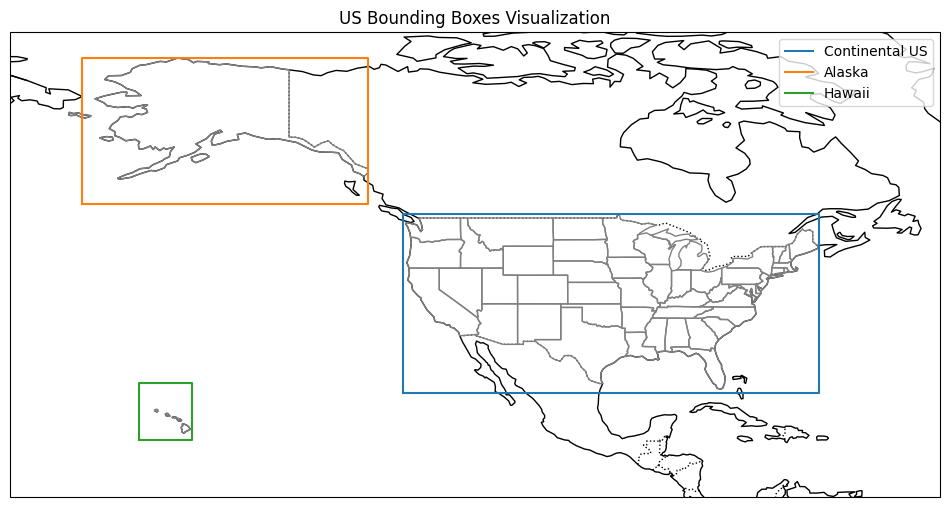

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np


fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([-180, -50, 10, 75], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, edgecolor='gray')

bounding_boxes = {
    "Continental US": [[24.5, 49.5], [-125.0, -66.95]],
    "Alaska": [[51.0, 71.4], [-170.0, -129.9]], 
    "Hawaii": [[17.9, 26], [-162.0, -154.5]]
}

for region, ((lat_min, lat_max), (lon_min, lon_max)) in bounding_boxes.items():
    lats = [lat_min, lat_max, lat_max, lat_min, lat_min]
    lons = [lon_min, lon_min, lon_max, lon_max, lon_min]
    ax.plot(lons, lats, transform=ccrs.PlateCarree(), label=region)

ax.legend()
plt.title("US Bounding Boxes Visualization")
plt.show()


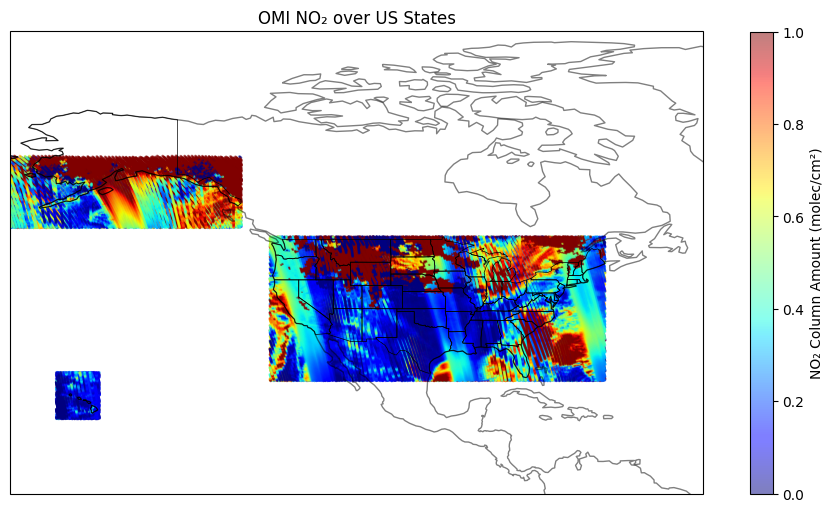

In [12]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-170, -50, 5, 85], crs=ccrs.PlateCarree()) 
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, alpha=0.5)
scatter = ax.scatter(global_longitude, global_latitude, c=global_cloudFraction, s=1, cmap='jet', transform=ccrs.PlateCarree(), alpha=0.5)
plt.colorbar(scatter, label='NO₂ Column Amount (molec/cm²)', orientation='vertical')
plt.title('OMI NO₂ over US States')
plt.show()

Perfect. Our bounding box and data filtration logic is valid. Lets process data files one month at a time and export them to not run out of memory.

In [8]:
import random

random.sample(omi_no2_links, 10)

['s3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2020/042/OMI-Aura_L2-OMI_MINDS_NO2_2020m0211t1604-o082852_v01-01-2022m0210t053236.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2020/038/OMI-Aura_L2-OMI_MINDS_NO2_2020m0207t1131-o082791_v01-01-2022m0210t052904.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2021/207/OMI-Aura_L2-OMI_MINDS_NO2_2021m0726t1505-o090584_v01-01-2022m0210t121032.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2021/306/OMI-Aura_L2-OMI_MINDS_NO2_2021m1102t2202-o092030_v01-01-2022m0210t134302.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2019/111/OMI-Aura_L2-OMI_MINDS_NO2_2019m0421t1205-o078539_v01-01-2022m0210t024711.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2020/132/OMI-Aura_L2-OMI_MINDS_NO2_2020m0511t1830-o084164_v01-01-2022m0210t062259.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2018/290/OMI-Aura_L2-OMI_MINDS_NO2_2018m1017

In [9]:
import re

def get_s3links_for_selected_date(year: str, month:str) -> list[str]:
    """
    Get the S3 links for a specific year and month.
    """
    month_str = f"{int(month):02d}"
    pattern = re.compile(rf'.*OMI_MINDS_NO2_{year}m{month_str}\d{{2}}t\d{{4}}.*\.nc$')
    files = sorted([file for file in omi_no2_links if pattern.search(file)])
    return files

In [9]:
def process_data_monthly(year: str, month: str):
    omi_no2_links_for_selected_YYYYMM = get_s3links_for_selected_date(year, month)
    global_latitude = []
    global_longitude = []
    global_ColumnAmountNO2 = []
    global_cloudFraction = []
    global_LAT1 = []
    global_LAT2 = []
    global_LAT3 = []
    global_LAT4 = []
    global_LON1 = []
    global_LON2 = []
    global_LON3 = []
    global_LON4 = []
    global_date = []

    for current_file in tqdm(omi_no2_links_for_selected_YYYYMM):
        with s3_fs.open(current_file, mode="rb") as f:
            dataset = nc.Dataset("in-memory.nc", memory=f.read())

        filename = os.path.basename(current_file)
        date = filename.split("OMI-Aura_L2-OMI_MINDS_NO2_")[1][:9]
        ColumnAmountNO2 = dataset.groups["SCIENCE_DATA"]["ColumnAmountNO2"][:].filled(np.nan).reshape(-1)
        cloudFraction = dataset.groups["ANCILLARY_DATA"]["CloudFraction"][:].filled(np.nan).reshape(-1)
        latitude = dataset.groups["GEOLOCATION_DATA"]["Latitude"][:].filled(np.nan).reshape(-1)
        longitude = dataset.groups["GEOLOCATION_DATA"]["Longitude"][:].filled(np.nan).reshape(-1)
        corner_latitude = dataset.groups["GEOLOCATION_DATA"]["FoV75CornerLatitude"][:].reshape(-1, 4)
        corner_longitude = dataset.groups["GEOLOCATION_DATA"]["FoV75CornerLongitude"][:].reshape(-1, 4)
        LAT1 = corner_latitude[:, 0]
        LAT2 = corner_latitude[:, 1]
        LAT3 = corner_latitude[:, 2]
        LAT4 = corner_latitude[:, 3]
        LON1 = corner_longitude[:, 0]
        LON2 = corner_longitude[:, 1]
        LON3 = corner_longitude[:, 2]
        LON4 = corner_longitude[:, 3]
        date = np.repeat(date, ColumnAmountNO2.shape[0])

        boolean_mask = np.array([is_over_us_state(lat, lon) for lat, lon in zip(latitude, longitude)])

        ColumnAmountNO2 = ColumnAmountNO2[boolean_mask]
        cloudFraction = cloudFraction[boolean_mask]
        latitude = latitude[boolean_mask]
        longitude = longitude[boolean_mask]
        LAT1 = LAT1[boolean_mask]
        LAT2 = LAT2[boolean_mask]
        LAT3 = LAT3[boolean_mask]
        LAT4 = LAT4[boolean_mask]
        LON1 = LON1[boolean_mask]
        LON2 = LON2[boolean_mask]
        LON3 = LON3[boolean_mask]
        LON4 = LON4[boolean_mask]
        date = date[boolean_mask]

        global_latitude.extend(latitude)
        global_longitude.extend(longitude)
        global_ColumnAmountNO2.extend(ColumnAmountNO2)
        global_cloudFraction.extend(cloudFraction)
        global_LAT1.extend(LAT1)
        global_LAT2.extend(LAT2)
        global_LAT3.extend(LAT3)
        global_LAT4.extend(LAT4)
        global_LON1.extend(LON1)
        global_LON2.extend(LON2)
        global_LON3.extend(LON3)
        global_LON4.extend(LON4)
        global_date.extend(date)

        dataset.close()

    df = pd.DataFrame({
        "latitude": global_latitude,
        "longitude": global_longitude,
        "ColumnAmountNO2": global_ColumnAmountNO2,
        "cloudFraction": global_cloudFraction,
        "LAT1": global_LAT1,
        "LAT2": global_LAT2,
        "LAT3": global_LAT3,
        "LAT4": global_LAT4,
        "LON1": global_LON1,
        "LON2": global_LON2,
        "LON3": global_LON3,
        "LON4": global_LON4,
        "date": global_date
    })
    df.to_parquet(f"omi_no2_data_{year}_{month}.parquet")

In [10]:
def process_data_monthly(year: str, month: str):
    try:
        omi_no2_links_for_selected_YYYYMM = get_s3links_for_selected_date(year, month)
        
        dfs = []

        for current_file in tqdm(omi_no2_links_for_selected_YYYYMM):
            try:
                with s3_fs.open(current_file, mode="rb") as f:
                    with nc.Dataset("in-memory.nc", memory=f.read()) as dataset:
                        filename = os.path.basename(current_file)
                        date = filename.split("OMI-Aura_L2-OMI_MINDS_NO2_")[1][:9]
                        
                        # Extract data
                        ColumnAmountNO2 = dataset.groups["SCIENCE_DATA"]["ColumnAmountNO2"][:].filled(np.nan).reshape(-1)
                        cloudFraction = dataset.groups["ANCILLARY_DATA"]["CloudFraction"][:].filled(np.nan).reshape(-1)
                        latitude = dataset.groups["GEOLOCATION_DATA"]["Latitude"][:].filled(np.nan).reshape(-1)
                        longitude = dataset.groups["GEOLOCATION_DATA"]["Longitude"][:].filled(np.nan).reshape(-1)
                        corner_latitude = dataset.groups["GEOLOCATION_DATA"]["FoV75CornerLatitude"][:].reshape(-1, 4)
                        corner_longitude = dataset.groups["GEOLOCATION_DATA"]["FoV75CornerLongitude"][:].reshape(-1, 4)
                        
                        # Create boolean mask
                        boolean_mask = np.array([is_over_us_state(lat, lon) for lat, lon in zip(latitude, longitude)])
                        
                        # Filter data
                        filtered_data = {
                            "latitude": latitude[boolean_mask],
                            "longitude": longitude[boolean_mask],
                            "ColumnAmountNO2": ColumnAmountNO2[boolean_mask],
                            "cloudFraction": cloudFraction[boolean_mask],
                            "LAT1": corner_latitude[:, 0][boolean_mask],
                            "LAT2": corner_latitude[:, 1][boolean_mask],
                            "LAT3": corner_latitude[:, 2][boolean_mask],
                            "LAT4": corner_latitude[:, 3][boolean_mask],
                            "LON1": corner_longitude[:, 0][boolean_mask],
                            "LON2": corner_longitude[:, 1][boolean_mask],
                            "LON3": corner_longitude[:, 2][boolean_mask],
                            "LON4": corner_longitude[:, 3][boolean_mask],
                            "date": np.repeat(date, np.sum(boolean_mask))
                        }
                        
                        dfs.append(pd.DataFrame(filtered_data))
            
            except Exception as e:
                print(f"Error processing file {current_file}: {str(e)}")
                continue

        if dfs:
            final_df = pd.concat(dfs, ignore_index=True)
            output_path = f"omi_no2_data_{year}_{month}.parquet"
            final_df.dropna(inplace=True)
            final_df.reset_index(drop=True, inplace=True)
            final_df.to_parquet(output_path)
        else:
            print("No valid data processed for the given month.")

        return True 
    except Exception as e:
        print(f"Error processing data for {year}-{month}: {str(e)}")
        return False

In [11]:
from joblib import Parallel, delayed

In [12]:
def proces_data_in_parallel(year_selected: str, num_cores= 6):
    """
    This function will process multiple months in parallel for a given year
    """
    months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    Parallel(n_jobs=num_cores)(delayed(process_data_monthly)(year, month) for year in [year_selected] for month in months)

In [ ]:
proces_data_in_parallel("2018")
proces_data_in_parallel("2019")
proces_data_in_parallel("2020")

In [13]:
proces_data_in_parallel("2020")

100%|██████████| 414/414 [04:32<00:00,  1.52it/s]


In [14]:
proces_data_in_parallel("2021")

100%|██████████| 432/432 [04:38<00:00,  1.55it/s]


In [15]:
proces_data_in_parallel("2022")

100%|██████████| 409/409 [03:55<00:00,  1.73it/s]


Now that we have exported OMI NO2 daily data for each month, lets combine them all into a single parquet file.

In [3]:
files_path = "Data/NO2/"
files = os.listdir(files_path)
files = [os.path.join(files_path, file) for file in files if file.endswith(".parquet")]
files = sorted(files)

In [4]:
len(files), files[0], files[-1]

(60,
 'Data/NO2/omi_no2_data_2018_01.parquet',
 'Data/NO2/omi_no2_data_2022_12.parquet')

In [5]:
df = pd.DataFrame()
for file in tqdm(files):
    df_temp = pd.read_parquet(file)
    df = pd.concat([df, df_temp], ignore_index=True)

100%|██████████| 60/60 [00:25<00:00,  2.33it/s]


In [6]:
df.to_parquet("OMI_NO2_US_2018_2022_COMBINED.parquet")

# Getting Raw Datasets

We can get County Level dataset from CDC's PLACES

1. 2022: https://data.cdc.gov/500-Cities-Places/PLACES-County-Data-GIS-Friendly-Format-2024-releas/i46a-9kgh/about_data
2. 2021: https://data.cdc.gov/500-Cities-Places/PLACES-County-Data-GIS-Friendly-Format-2023-releas/7cmc-7y5g/about_data
3. 2020: https://data.cdc.gov/500-Cities-Places/PLACES-County-Data-GIS-Friendly-Format-2022-releas/xyst-f73f/about_data
4. 2019: https://data.cdc.gov/500-Cities-Places/PLACES-County-Data-GIS-Friendly-Format-2021-releas/kmvs-jkvx/about_data
5. 2018: https://data.cdc.gov/500-Cities-Places/PLACES-County-Data-GIS-Friendly-Format-2020-releas/mssc-ksj7/about_data

In [19]:
df = spark.read.csv(r"C:\Users\neupa\Downloads\PLACES__Local_Data_for_Better_Health__County_Data_2023_release (1).csv", header=True, inferSchema=True)

In [21]:
df.show(5)

+----+---------+---------+------------+----------+---------------+--------------------+---------------+----------------+----------+--------------------------+-------------------+--------------------+---------------------+---------------+----------+----------+----------+---------------+-------------------+--------------------+
|Year|StateAbbr|StateDesc|LocationName|DataSource|       Category|             Measure|Data_Value_Unit| Data_Value_Type|Data_Value|Data_Value_Footnote_Symbol|Data_Value_Footnote|Low_Confidence_Limit|High_Confidence_Limit|TotalPopulation|LocationID|CategoryID| MeasureId|DataValueTypeID|Short_Question_Text|         Geolocation|
+----+---------+---------+------------+----------+---------------+--------------------+---------------+----------------+----------+--------------------------+-------------------+--------------------+---------------------+---------------+----------+----------+----------+---------------+-------------------+--------------------+
|2021|       TX|

In [22]:
df.groupBy("Measure").count().show()

+--------------------+-----+
|             Measure|count|
+--------------------+-----+
|Fecal occult bloo...| 6288|
|Obesity among adu...| 6154|
|Physical health n...| 6154|
|Self-care disabil...| 6154|
|Binge drinking am...| 6154|
|Any disability am...| 6154|
|No leisure-time p...| 6154|
|Visits to dentist...| 6288|
|Vision disability...| 6154|
|Sleeping less tha...| 6288|
|High blood pressu...| 6154|
|Arthritis among a...| 6154|
|Visits to doctor ...| 6154|
|Mammography use a...| 6288|
|Older adult women...| 6288|
|Cholesterol scree...| 6154|
|Fair or poor self...| 6154|
|Stroke among adul...| 6154|
|Depression among ...| 6154|
|Diagnosed diabete...| 6154|
+--------------------+-----+
only showing top 20 rows



In [13]:
# https://data.cdc.gov/500-Cities-Places/PLACES-County-Data-GIS-Friendly-Format-2024-releas/i46a-9kgh/about_data

In [22]:
import pandas as pd
df = pd.read_csv(r"C:\Users\neupa\Downloads\PLACES__Local_Data_for_Better_Health__County_Data_2024_release_20250321.csv")

C:\Users\neupa\AppData\Local\Temp\ipykernel_16008\1694322216.py:2: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\neupa\Downloads\PLACES__Local_Data_for_Better_Health__County_Data_2024_release_20250321.csv")


In [24]:
df["Year"].value_counts()

Year
2022    216262
2021     24624
Name: count, dtype: int64

In [25]:
df = df[df["Year"] == 2022]

In [26]:
df

,Year,StateAbbr,StateDesc,LocationName,DataSource,Category,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,...,Low_Confidence_Limit,High_Confidence_Limit,TotalPopulation,TotalPop18plus,LocationID,CategoryID,MeasureId,DataValueTypeID,Short_Question_Text,Geolocation
0,2022,US,United States,NaN,BRFSS,Health Outcomes,Diagnosed diabetes among adults,%,Crude prevalence,12.0,...,11.8,12.2,333287557,260836730,59,HLTHOUT,DIABETES,CrdPrv,Diabetes,NaN
1,2022,CO,Colorado,Lake,BRFSS,Health Outcomes,Stroke among adults,%,Crude prevalence,2.4,...,2.2,2.6,7327,5862,8065,HLTHOUT,STROKE,CrdPrv,Stroke,POINT (-106.344971513974 39.2024367117474)
2,2022,CO,Colorado,Mesa,BRFSS,Disability,Hearing disability among adults,%,Crude prevalence,7.1,...,6.3,8.0,158636,126505,8077,DISABLT,HEARING,CrdPrv,Hearing Disability,POINT (-108.466537411781 39.0183551841305)
3,2022,CT,Connecticut,Capitol,BRFSS,Health Outcomes,Arthritis among adults,%,Crude prevalence,26.2,...,24.4,28.4,981447,783914,9110,HLTHOUT,ARTHRITIS,CrdPrv,Arthritis,POINT (-72.5720699045246 41.8184543884154)
4,2022,FL,Florida,Alachua,BRFSS,Health Outcomes,Arthritis among adults,%,Age-adjusted prevalence,24.4,...,21.7,27.2,284030,234132,12001,HLTHOUT,ARTHRITIS,AgeAdjPrv,Arthritis,POINT (-82.3582005204153 29.6751856950068)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240879,2022,WI,Wisconsin,Fond du Lac,BRFSS,Health Outcomes,Stroke among adults,%,Crude prevalence,3.7,...,3.3,4.0,103836,82265,55039,HLTHOUT,STROKE,CrdPrv,Stroke,POINT (-88.4883433780916 43.7536089759286)
240882,2022,WI,Wisconsin,Trempealeau,BRFSS,Health Outcomes,Depression among adults,%,Age-adjusted prevalence,24.5,...,20.9,28.2,30899,23116,55121,HLTHOUT,DEPRESSION,AgeAdjPrv,Depression,POINT (-91.3584214806691 44.3039450660913)
240883,2022,WI,Wisconsin,Door,BRFSS,Prevention,Visited dentist or dental clinic in the past y...,%,Age-adjusted prevalence,64.3,...,60.1,67.8,30526,25807,55029,PREVENT,DENTAL,AgeAdjPrv,Dental Visit,POINT (-87.3114193001272 44.9500144269812)
240884,2022,WI,Wisconsin,Marathon,BRFSS,Disability,Self-care disability among adults,%,Crude prevalence,3.2,...,2.9,3.5,137958,107333,55073,DISABLT,SELFCARE,CrdPrv,Self-care Disability,POINT (-89.7588560093353 44.8983004431375)


In [18]:
df["Year"] = 2022

In [19]:
selected_column = ["Year", 'StateAbbr', 'StateDesc', 'CountyName', 'CountyFIPS', 'TotalPopulation', "TotalPop18plus", 'CASTHMA_CrudePrev', 'CASTHMA_Crude95CI', 'CASTHMA_AdjPrev', 'CASTHMA_Adj95CI', "Geolocation"]

In [20]:
df = df[selected_column]

In [21]:
df[df.CountyName == "Otero"]

,Year,StateAbbr,StateDesc,CountyName,CountyFIPS,TotalPopulation,TotalPop18plus,CASTHMA_CrudePrev,CASTHMA_Crude95CI,CASTHMA_AdjPrev,CASTHMA_Adj95CI,Geolocation
2676,2022,CO,Colorado,Otero,8089,18303,14058,11.8,"(10.4, 13.3)",12.0,"(10.6, 13.5)",POINT (-103.717022312193 37.9021617548008)
2866,2022,NM,New Mexico,Otero,35035,68823,53831,11.4,"(10.0, 12.9)",11.6,"(10.1, 13.0)",POINT (-105.741478524611 32.6132896393527)
